In [1]:
import tensorflow as tf
import numpy as np
import util
import matplotlib.pyplot as plt
import io
from PIL import Image
import os
from tqdm import tqdm_notebook as tqdm


from callbacks.AutoEncoderSummary import AutoEncoderSummary

In [2]:
tf.__version__


'1.12.0'

In [3]:
x_train, y_train, x_test, y_test = util.getKaggleMNIST()

In [15]:
original_dim = x_train.shape[1]

# network parameters
input_shape = (original_dim,)
intermediate_dim = 512
batch_size = 128
latent_dim = 128
epochs = 50

In [16]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + z_log_var * epsilon

In [17]:
# VAE model = encoder + decoder
# build encoder model
inputs = tf.keras.layers.Input(shape=input_shape, name="encoder_input")
x = tf.keras.layers.Dense(intermediate_dim, activation="relu")(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)

var_activation = tf.keras.activations.softplus
z_log_var = tf.keras.layers.Dense(
    latent_dim, name="z_log_var", activation=var_activation
)(x)

# use reparameterization trick to push the sampling out as input
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name="z")(
    [z_mean, z_log_var]
)

# instantiate encoder model
encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 128)          65664       dense_3[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 128)          65664       dense_3[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [18]:
# build decoder model
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name="z_sampling")
x = tf.keras.layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation="sigmoid")(x)

# instantiate decoder model
decoder = tf.keras.models.Model(latent_inputs, outputs, name="decoder")
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total params: 468,240
Trainable params: 468,240
Non-trainable params: 0
_________________________________________________________________


In [19]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.models.Model(inputs, outputs, name="vae_mlp")

In [20]:
# Losses
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

kl_loss = -tf.keras.backend.log(z_log_var) + 0.5 * (
    tf.keras.backend.pow(z_log_var, 2) + tf.keras.backend.pow(z_mean, 2)
)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss += -0.5

In [21]:
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 128), (None, 128) 533248    
_________________________________________________________________
decoder (Model)              (None, 784)               468240    
Total params: 1,001,488
Trainable params: 1,001,488
Non-trainable params: 0
_________________________________________________________________


In [22]:
data_to_plot = []
index = np.random.choice(range(x_train.shape[0]), 10)
data_train = x_train[index]
index = np.random.choice(range(x_test.shape[0]), 10)
data_test = x_test[index]
data_to_plot.append((data_train, "train"))
data_to_plot.append((data_test, "valid"))

In [23]:
summaries_dir = "summaries/vae_kaggle_mnist"
tf.gfile.DeleteRecursively(summaries_dir) if tf.gfile.Exists(summaries_dir) else None
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=summaries_dir)

In [24]:
vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, None),
    callbacks=[
        tensorboard_callback,
        AutoEncoderSummary(tensorboard_callback, data_to_plot, update_freq=1),
    ],
)

Train on 41000 samples, validate on 1000 samples
Epoch 1/50
41000/41000 [==============================] - 9s 208us/step - loss: 242.2134 - val_loss: 209.3837
Epoch 2/50
41000/41000 [==============================] - 9s 209us/step - loss: 202.6035 - val_loss: 196.9436
Epoch 3/50
41000/41000 [==============================] - 9s 208us/step - loss: 191.7341 - val_loss: 188.4113
Epoch 4/50
41000/41000 [==============================] - 11s 278us/step - loss: 184.3262 - val_loss: 182.7249
Epoch 5/50
41000/41000 [==============================] - 8s 200us/step - loss: 179.8596 - val_loss: 179.4139
Epoch 6/50
41000/41000 [==============================] - 8s 194us/step - loss: 177.2598 - val_loss: 177.2279
Epoch 7/50
41000/41000 [==============================] - 10s 234us/step - loss: 175.4351 - val_loss: 175.8127
Epoch 8/50
41000/41000 [==============================] - 10s 235us/step - loss: 173.9854 - val_loss: 174.4898
Epoch 9/50
41000/41000 [==============================] - 10s 233us/

In [25]:
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm_notebook as tqdm

def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    elif np.allclose(low, high):
        return low
    omega = np.arccos(np.dot(low / np.linalg.norm(low), high / np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1 - val) * omega) / so * low + np.sin(val * omega) / so * high

def plot_image(image, animated=False):
    return plt.imshow(image, cmap='Greys_r', animated=True)

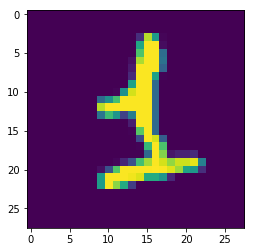

In [115]:
y = 1
x = x_test[y_test == y]
i = np.random.randint(len(x))
z_mean, z_stdd, z = encoder.predict(x[i:i+1])
start = z[0]
#z_mean, z_stdd, z
#plt.imshow(x[i:i+1].reshape(28,28))
#plt.show()

In [116]:
y = 3
x = x_test[y_test == y]
i = np.random.randint(len(x))
z_mean, z_stdd, z = encoder.predict(x[i:i+1])
z_mean, z_stdd, z
end = z[0]
# start, end

In [117]:
fig = plt.figure()
plt.grid(False)
ims = []
for frame in tqdm(np.sin(np.linspace(0, np.pi, num=100)), desc='Traversing latent space'):
    noise = np.expand_dims(slerp(frame, start, end), axis=0)
    pred = decoder.predict(noise)
    im = pred[0, ...].reshape(28,28)
    im = plot_image(im, animated=True)
    ims.append([im])
    
anim = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=0, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())